In [2]:
!pip install ultralytics opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.6 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import time


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Load nano model (fast for real-time)
model = YOLO('yolov8n.pt')

# Counters & history
entry_count = 0
exit_count = 0
track_history = defaultdict(lambda: {'prev_y': None})

# ROI line Y (dynamic)
line_y = None

# Frame size
width, height = 640, 480

print("YOLOv8 loaded. Person tracking enabled. Run next for JS webcam.")

YOLOv8 loaded. Person tracking enabled. Run next for JS webcam.


In [12]:
# JS for live webcam (adapted for smooth stream)
def start_webcam():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;
        var pendingTimeOut;
        function removeDom() {
           if (stream) {
               stream.getVideoTracks()[0].stop();
           }
           if (div) div.remove();
           div = null;
           video = null;
           imgElement = null;
           captureCanvas = null;
           labelElement = null;
        }
        async function createDom() {
          if (div !== null) {
            return stream;
          }
          div = document.createElement('div');
          div.style.border = '2px solid black';
          div.style.padding = '3px';
          div.style.width = '100%';
          div.style.clear = 'both';
          document.body.appendChild(div);
          const modelOut = document.createElement('div');
          modelOut.innerHTML = "<span>Status: Live Detection</span>";
          labelElement = document.createElement('span');
          labelElement.innerText = 'Ready';
          labelElement.style.fontWeight = 'bold';
          modelOut.appendChild(labelElement);
          div.appendChild(modelOut);
          video = document.createElement('video');
          video.style.display = 'block';
          video.width = div.clientWidth - 6;
          video.setAttribute('playsinline', '');
          video.onclick = () => { if (pendingTimeOut) clearTimeout(pendingTimeOut); };
          div.appendChild(video);
          stream = await navigator.mediaDevices.getUserMedia({video: true});
          div.appendChild(modelOut);
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
          video.setAttribute('autoplay', '');
          video.setAttribute('muted', '');
          video.srcObject = stream;
          video.addEventListener('loadeddata', () => { onAnimationFrame(); });
          video.addEventListener('play', () => { onAnimationFrame(); });

          // Make video, stream and div accessible globally
          window.video = video;
          window.stream = stream;
          window.div = div;


          return stream;
        }
        function onAnimationFrame() {
          if (!video || !captureCanvas) return;
          if (pendingTimeOut) clearTimeout(pendingTimeOut);
          pendingTimeOut = setTimeout(() => {
            var canvas = document.createElement('canvas');
            canvas.width = captureCanvas.width;
            canvas.height = captureCanvas.height;
            canvas.getContext('2d').drawImage(video, 0, 0);
            var b64image = canvas.toDataURL('image/jpeg', 0.8);
            google.colab.kernel.invokeFunction('notebook_code_cell', [b64image], {});
          }, 33);  // ~30 FPS target
        }
        createDom();
    ''')
    display(js)

# Register callback
from google.colab import output
output.register_callback('notebook_code_cell', lambda b64img: b64img)

In [6]:
# B64 to OpenCV image
def b64_to_cv2(b64_string):
    if b64_string.startswith('data:image'):
        b64_string = b64_string.split(',')[1]
    img_data = b64decode(b64_string)
    nparr = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img

# OpenCV to B64 for display
def cv2_to_b64(img):
    _, buffer = cv2.imencode('.jpg', img)
    img_b64 = b64encode(buffer).decode()
    return f"data:image/jpeg;base64,{img_b64}"

# Display in Colab
def show_frame(img_b64):
    display(HTML(f'<img src="{img_b64}" width=640 height=480 />'))

<IPython.core.display.Javascript object>

Webcam started! Point at doorway. Cross middle line to test counts.
Stop: Interrupt kernel (Runtime > Interrupt) or run Cell 7.



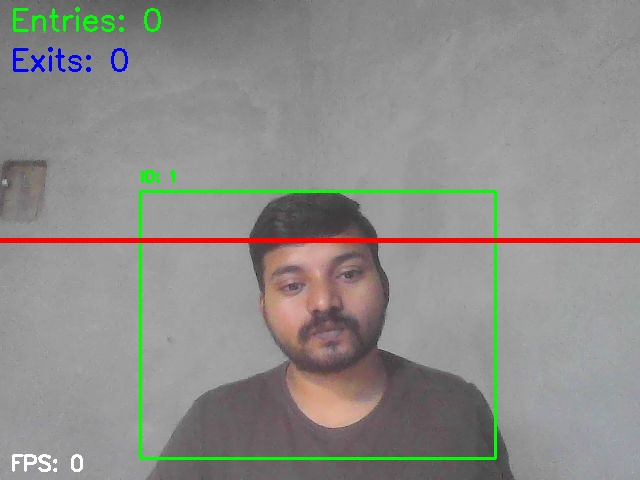


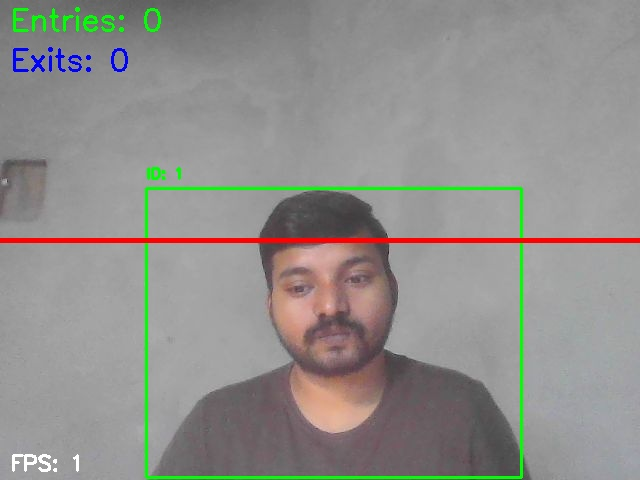


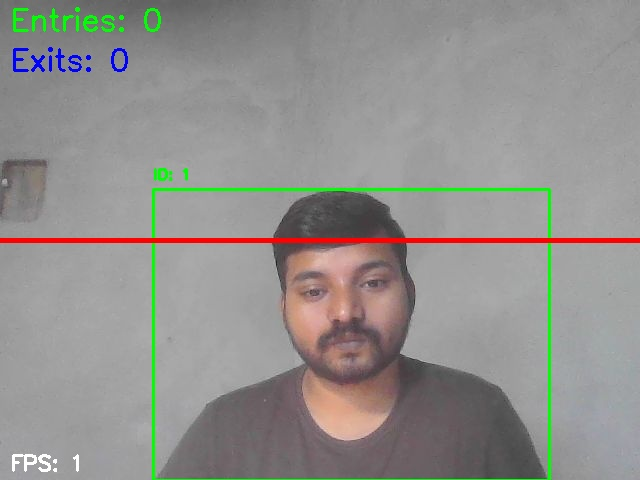


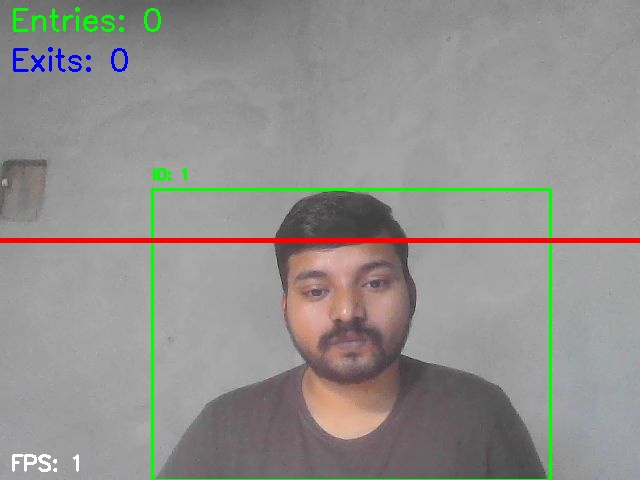


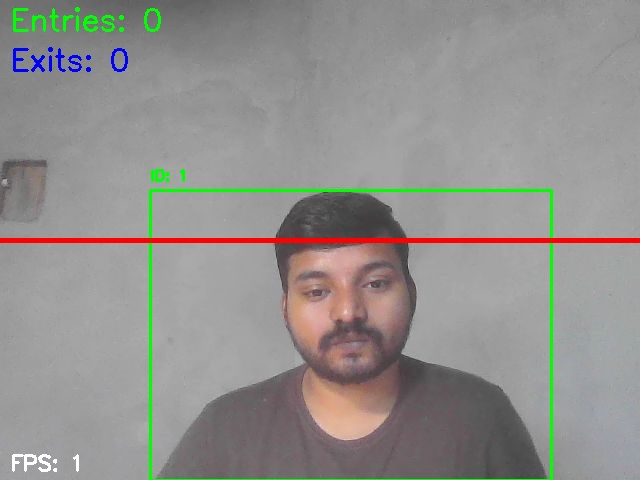


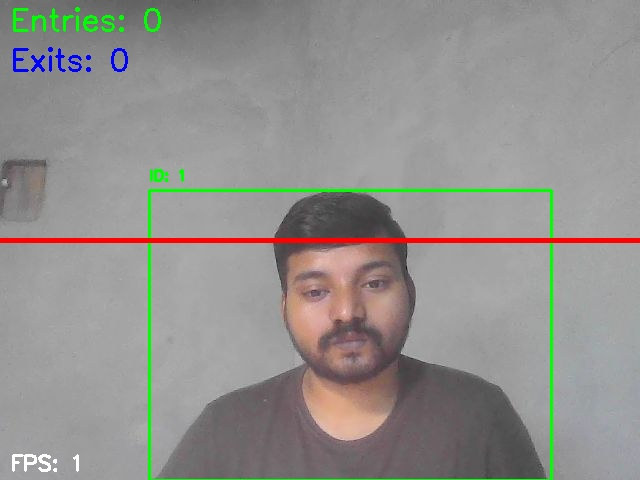


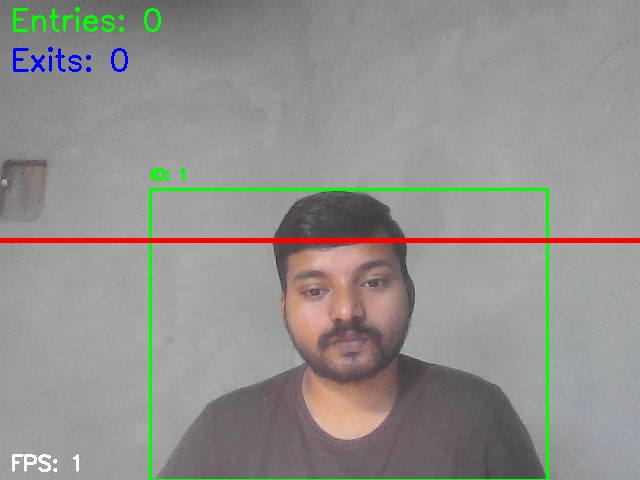


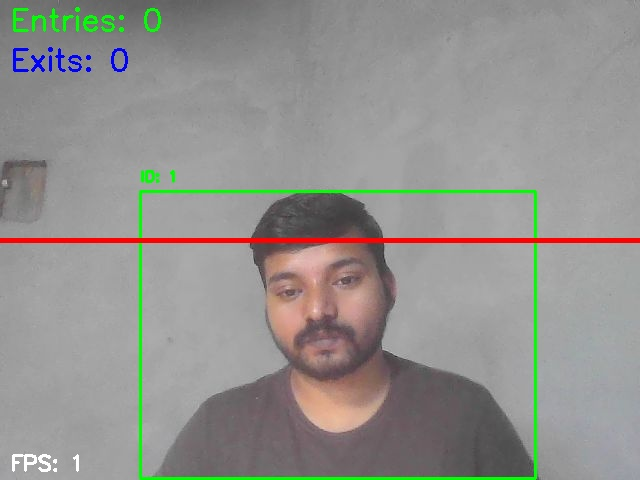


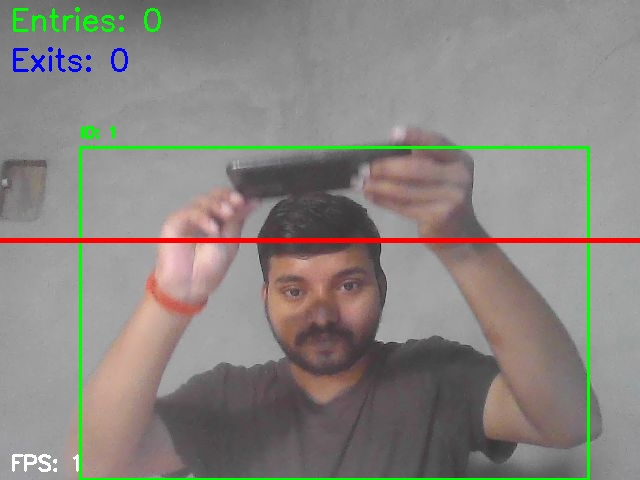


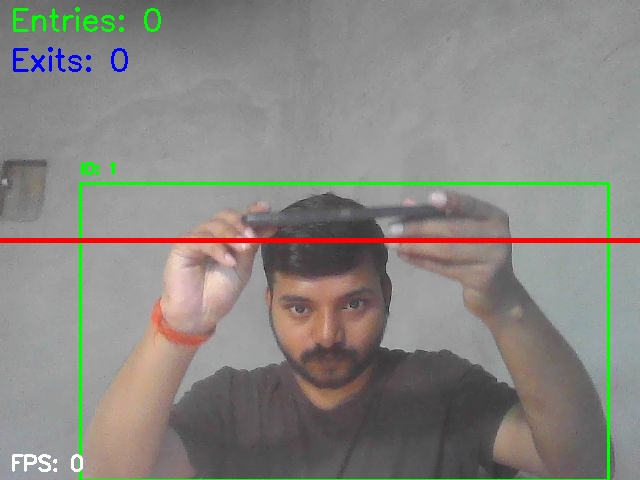


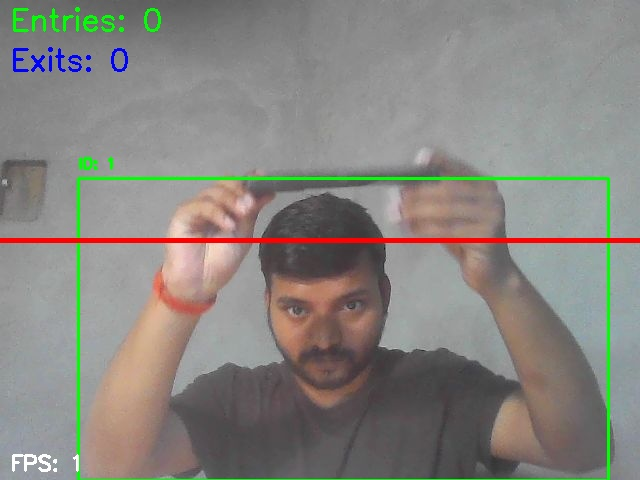


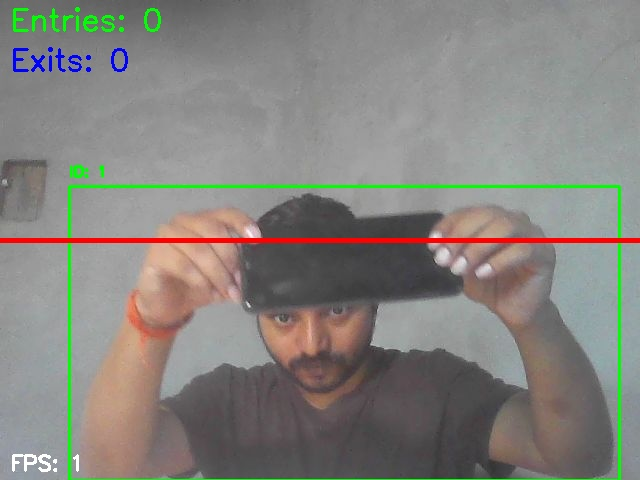


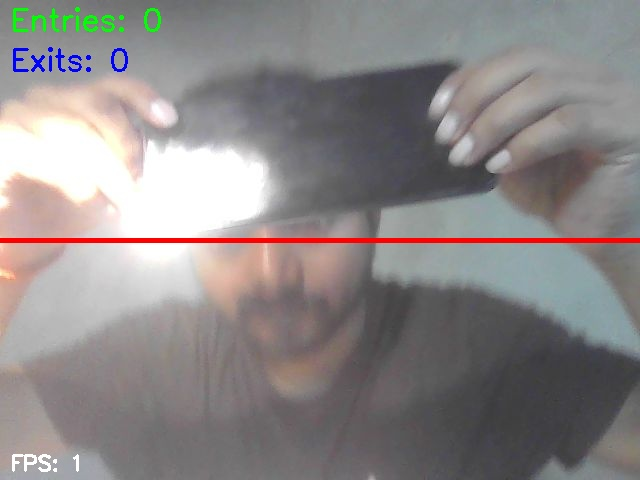


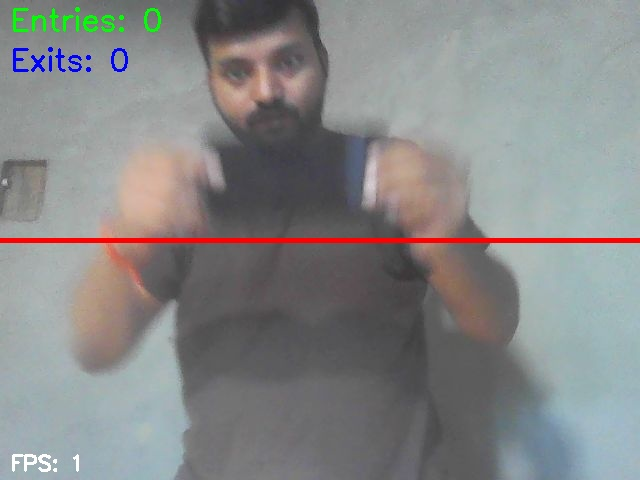


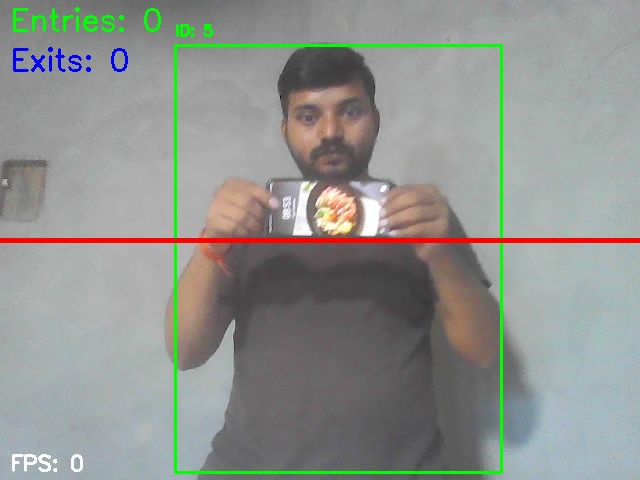

Exit detected! Total Exits: 1



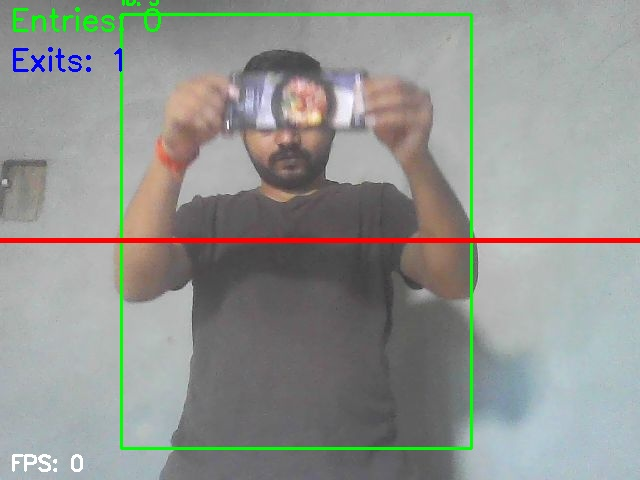

Entry detected! Total Entries: 1



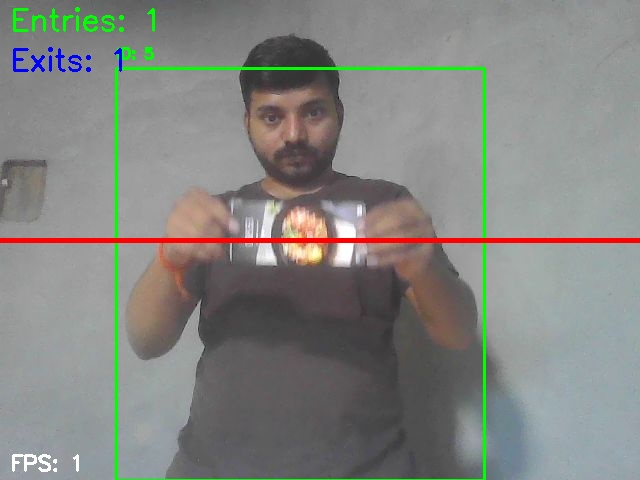

Exit detected! Total Exits: 2



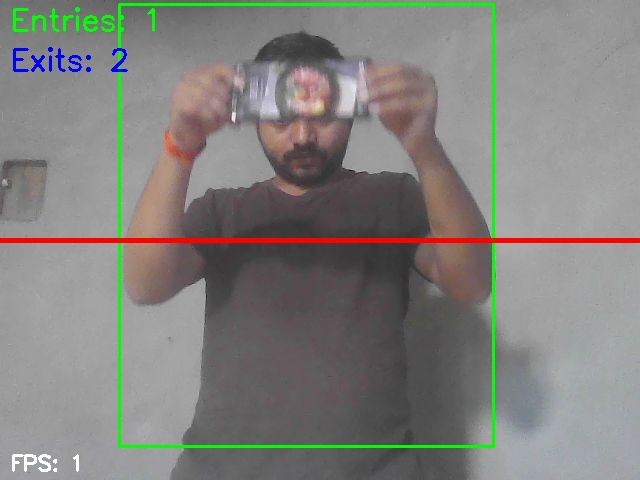

Entry detected! Total Entries: 2



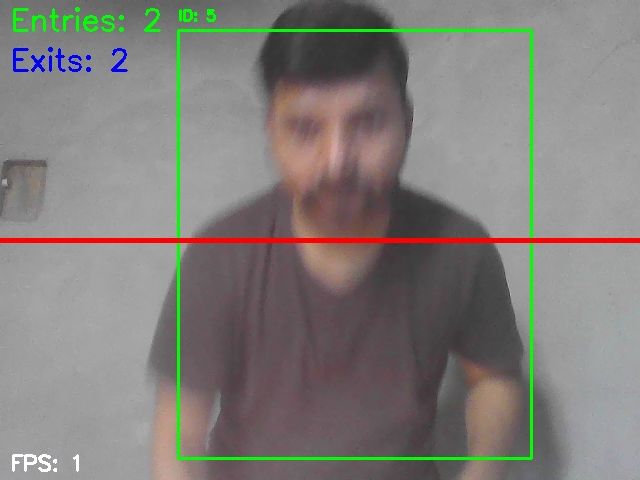


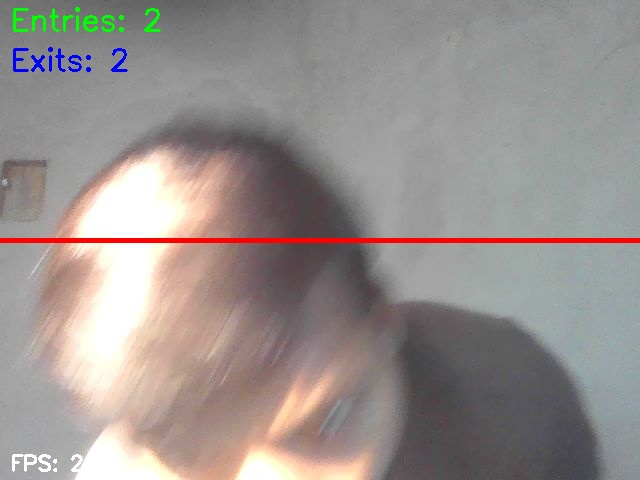


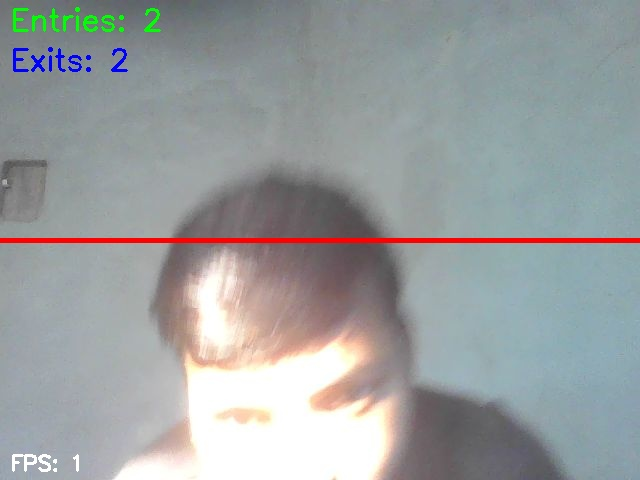


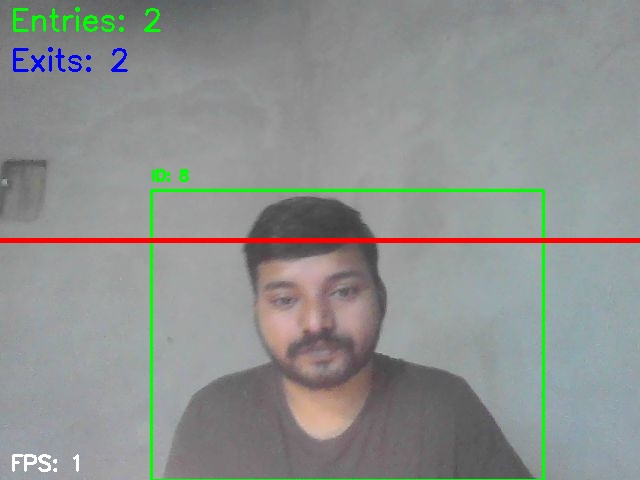


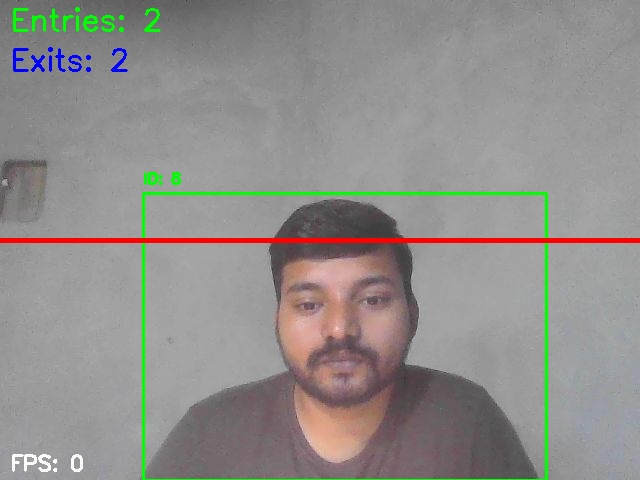


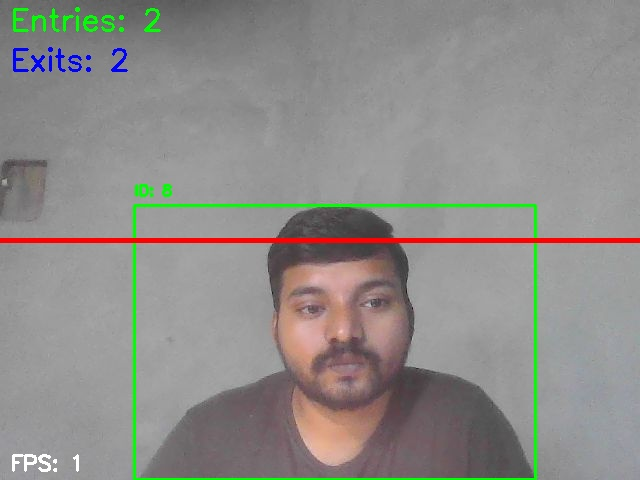


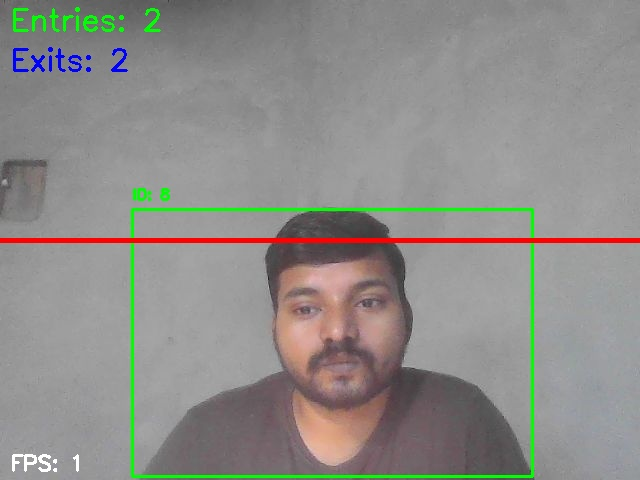


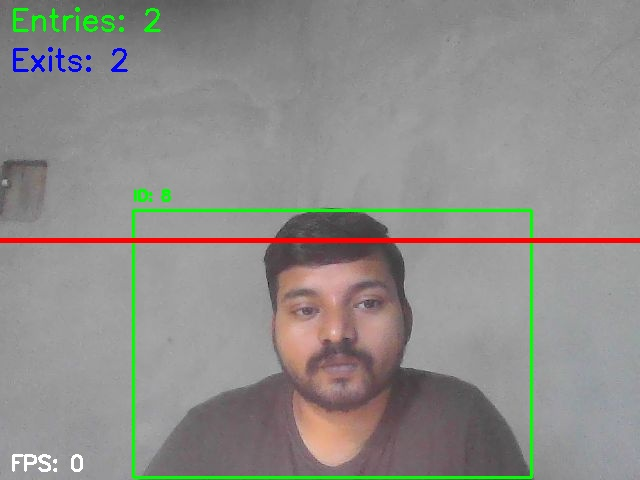


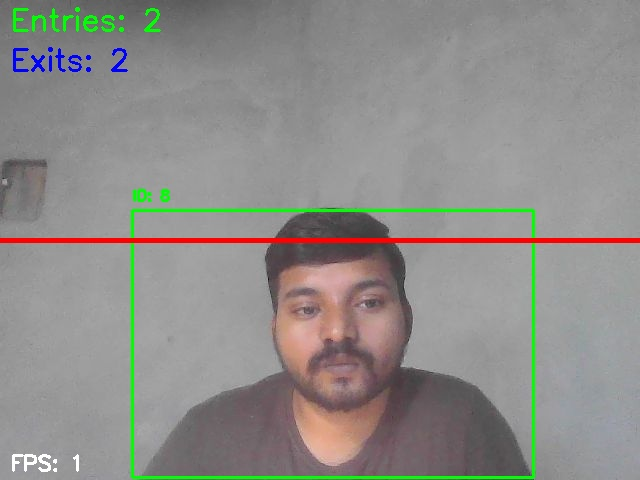


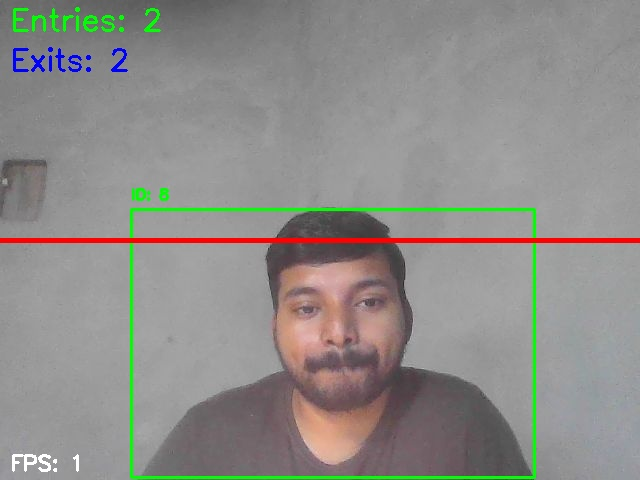


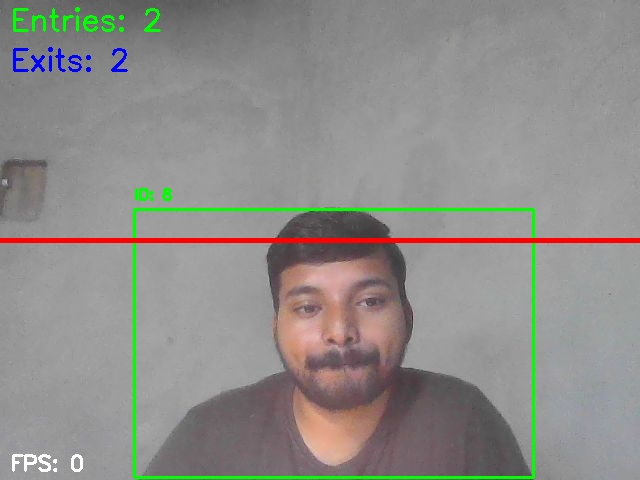


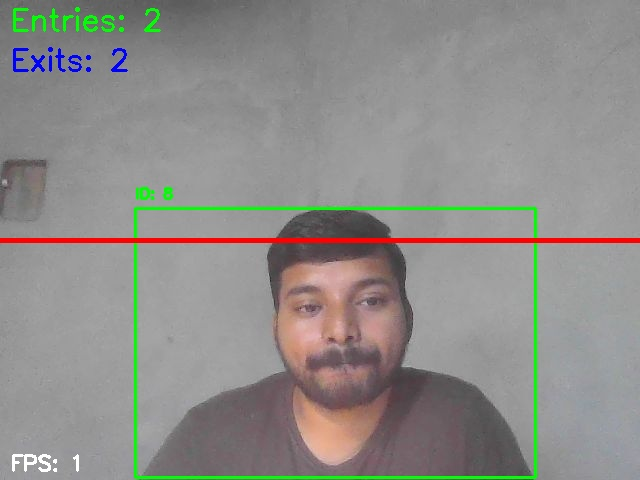


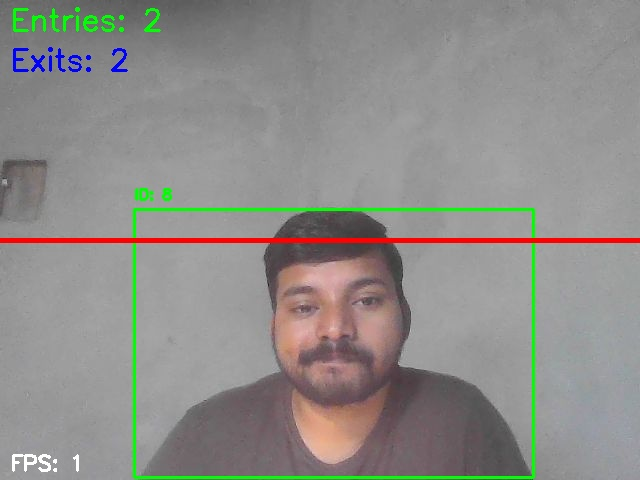


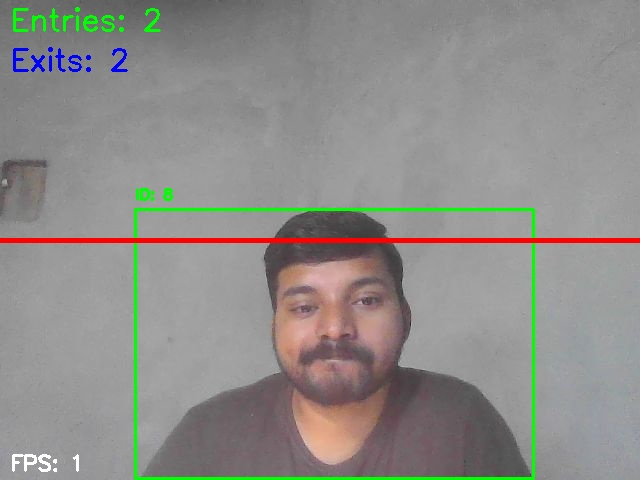


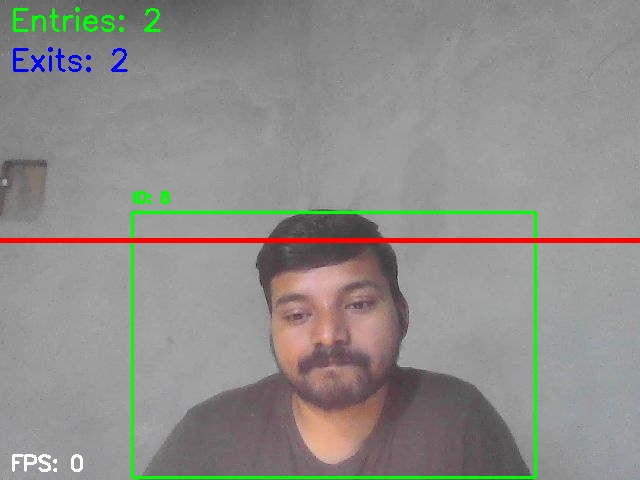


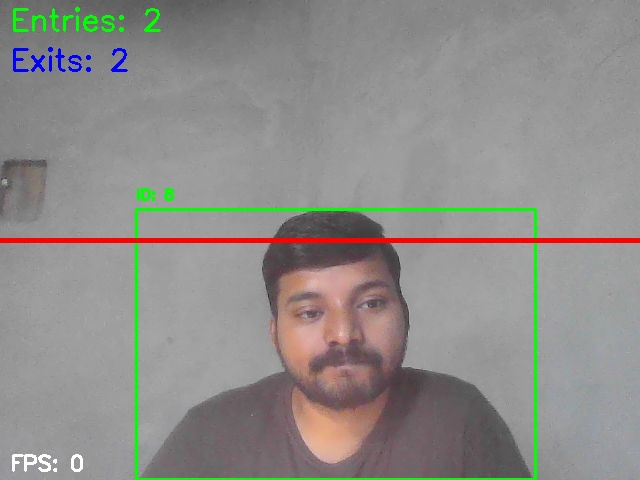


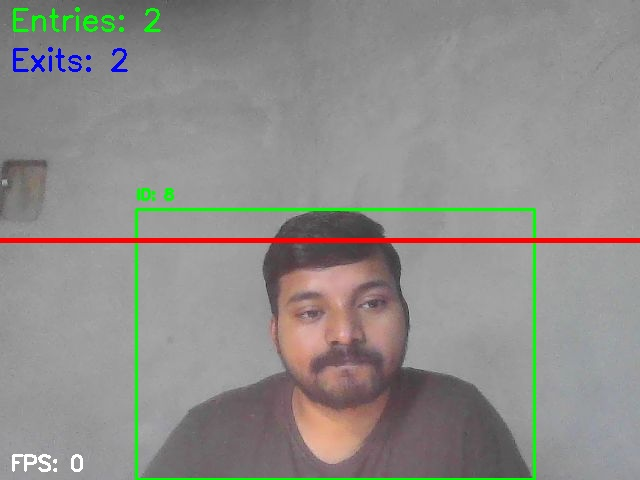

Stopped by user.


NameError: name 'files' is not defined

In [16]:
# Start webcam
start_webcam()

# FPS init
fps_time = time.time()
frame_count = 0

print("Webcam started! Point at doorway. Cross middle line to test counts.")
print("Stop: Interrupt kernel (Runtime > Interrupt) or run Cell 7.")

try:
    while True:
        # Get frame from JS (waits for new frame)
        js_reply = eval_js('canvas = document.createElement("canvas"); canvas.width = video.videoWidth; canvas.height = video.videoHeight; ctx = canvas.getContext("2d"); ctx.drawImage(video, 0, 0); canvas.toDataURL("image/jpeg", 0.8)')
        if not js_reply:
            break

        frame = b64_to_cv2(js_reply)
        if frame is None:
            continue

        h, w = frame.shape[:2]
        if line_y is None:
            line_y = h // 2
            print(f"ROI line at Y={line_y}. Entries: {entry_count}, Exits: {exit_count}")

        frame_count += 1

        # YOLO detection + tracking
        results = model.track(frame, persist=True, classes=[0], verbose=False)
        boxes = results[0].boxes

        if boxes is not None and len(boxes) > 0:
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                track_id = int(box.id[0].cpu().numpy()) if box.id is not None else -1

                if track_id != -1:
                    curr_y = (y1 + y2) // 2  # Centroid Y

                    if track_history[track_id]['prev_y'] is not None:
                        prev_y = track_history[track_id]['prev_y']
                        # Entry: Above to below
                        if prev_y <= line_y < curr_y:
                            entry_count += 1
                            print(f"Entry detected! Total Entries: {entry_count}")
                        # Exit: Below to above
                        elif prev_y > line_y >= curr_y:
                            exit_count += 1
                            print(f"Exit detected! Total Exits: {exit_count}")

                    track_history[track_id]['prev_y'] = curr_y

                    # Draw box & ID
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw ROI line (red)
        cv2.line(frame, (0, line_y), (w, line_y), (0, 0, 255), 3)

        # Draw counts
        cv2.putText(frame, f'Entries: {entry_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f'Exits: {exit_count}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # FPS
        fps = 1 / (time.time() - fps_time)
        fps_time = time.time()
        cv2.putText(frame, f'FPS: {int(fps)}', (10, h - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Display processed frame
        img_b64 = cv2_to_b64(frame)
        show_frame(img_b64)

        # Limit for demo (remove for infinite)
        if frame_count > 300:  # ~10s at 30 FPS
            break

except KeyboardInterrupt:
    print("Stopped by user.")

# Download the processed video with overlays
files.download('output_webcam.mp4')
print("Downloaded 'output_webcam.mp4' – use for submission screenshots/demo.")
print(f"\nSession End: Total Entries: {entry_count}, Exits: {exit_count}")



In [17]:
# Cleanup
eval_js('''
if (window.video && window.video.srcObject) {
    stream = window.video.srcObject;
    if (stream.getVideoTracks) {
        stream.getVideoTracks()[0].stop();
    }
}
if (window.div) {
    window.div.remove();
}
''')
print("Webcam stopped.")

Webcam stopped.
